In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import class_definitions as cd
import function_definitions as fd
import fish_kinematics as fk
import airfoil as ar

from scipy import linalg

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
dx = (0.5*(1-np.cos(beta)))
# uniform spacing
# dx = np.linspace(0.0, chord, 100)
x, y = ar.naca4(dx, 0.12, chord, 0.0, 0.30, True)

(-0.1, 0.1)

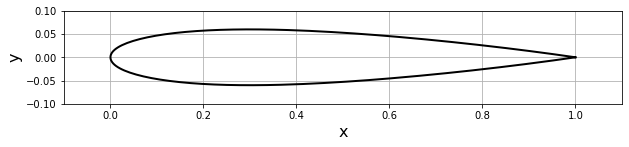

In [3]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

In [4]:
# discretize geoemetry into panels
panels = fd.define_panels(x, y, N=40)

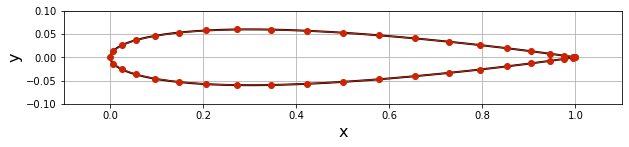

In [5]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

In [6]:
total_length = 1.0
velocity = 0.3478
WL = 2.5*total_length         # body wavelength [m]
k = 2*np.pi/WL                # wave number [radians/meter]
freq = 2.47                   # flapping frequency [Hz]
strouhal = 1.136               
A_t = velocity*strouhal/freq    # tail beat amplitude [m]
A_n = 0.01275/total_length
w = 2*np.pi*freq                # angular frequency [radians/sec]                                                         
x_pivot = 0.7                   # pivot in percent of body length

midline = fk.Carangiform(w, k, A_n, A_t, x_pivot, total_length)

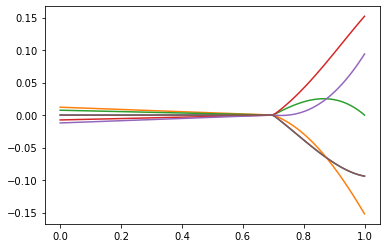

In [7]:
time = np.linspace(0, 1/freq, 6)
x_coordinates = np.linspace(0, 1.0, 100)

fig2, ax2 = plt.subplots()
for t in time:
    h = midline.rigid_motion(x_coordinates, t)
    ax2.plot(x_coordinates, h)